## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máme dataset v souboru `data.csv`. Udaje byly převzaty z https://www.kaggle.com/competitions/titanic/data

### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chceme predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Obsah projektu

* V notebooku načtěme data ze souboru `data.csv`. Vhodným způsobem si je rozdělme na podmnožiny, které nám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
  
* Proveďme základní předzpracování dat:
  * Projděme si jednotlivé příznaky a transformujme je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžeme vytvářet nové příznaky (na základě existujících).
  * Některé příznaky můžete také úplně zahodit.
  * Vypořádejme se s chybějícími hodnotami.

* Na připravená data postupně aplikujeme **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
  * Okomentujme vhodnost daného modelu pro daný typ úlohy.
  * Vyberme si hlavní hyperparametry k ladění a najděme jejich nejlepší hodnoty.
  * Pro model s nejlepšími hodnotami hyperparametrů spočtěme F1 skóre, nakreslete ROC křivku a určete AUC.
      
* Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněme, jakou přesnost můžete očekávat na nových datech, která jsme doposud neměli k dispozici.

In [604]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(palette='dark',style='darkgrid')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 110723
import sklearn.metrics as metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.neighbors import KNeighborsClassifier

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


# Načtěni dat

In [605]:
data = pd.read_csv('data.csv')
display(data.shape)
display(data.head(10))

(1000, 13)

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,3,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,4,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"
5,5,0,2,"Giles, Mr. Frederick Edward",male,21.0,1,0,28134,11.5000,NaN,S,"Cornwall / Camden, NJ"
6,6,0,3,"Williams, Mr. Leslie",male,28.5,0,0,54636,16.1000,NaN,S,NaN
7,7,0,3,"Johansson, Mr. Gustaf Joel",male,33.0,0,0,7540,8.6542,NaN,S,NaN
8,8,0,2,"Norman, Mr. Robert Douglas",male,28.0,0,0,218629,13.5000,NaN,S,Glasgow
9,9,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C,NaN


Nejprve vynechame duplicitni zaznamy:

In [606]:
data.drop_duplicates(inplace=True)

# Exploracni analyza dat

In [607]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        802 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      233 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  566 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 109.4+ KB


None

Dataset obsahuje 1000 příkladů a 12 features + cílovou proměnnou (survived). Dva z nich jsou float, 5 celých čísel a 6 objektů.

In [608]:
display(data.describe())

,ID,survived,pclass,age,sibsp,parch,fare
count,1000.000000,1000.00000,1000.000000,802.000000,1000.000000,1000.00000,999.000000
mean,499.500000,0.39800,2.288000,29.850686,0.496000,0.40200,34.264352
std,288.819436,0.48973,0.840096,14.328743,1.024223,0.91719,53.315077
min,0.000000,0.00000,1.000000,0.166700,0.000000,0.00000,0.000000
25%,249.750000,0.00000,1.750000,21.000000,0.000000,0.00000,7.925000
50%,499.500000,0.00000,3.000000,28.000000,0.000000,0.00000,14.458300
75%,749.250000,1.00000,3.000000,39.000000,1.000000,0.00000,31.275000
max,999.000000,1.00000,3.000000,80.000000,8.000000,9.00000,512.329200


Ted' uz vidime, ze prezilo 39,8% procent lidi. Takze vidime, ze věk cestujících se pohybuje od 0,4 do 80 let.

Take vidime, ze nektere veky se chybeji. Podivame se na to, kolik vlastne dat mizi:

In [609]:
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
cabin,767,76.7
home.dest,434,43.4
age,198,19.8
embarked,2,0.2
fare,1,0.1


Vidime, ze cabin a home.dest maji mnoho chybějících údajů, možná teto priznaky budeme muset vynechat. Věk lze nahradit mediánem
Zkusime vizualizovat a zjištit korelací mezi jednotlivymi priznaky a mezi priznakem a "survived"

## Sex, Age a Survived

<AxesSubplot:xlabel='sex', ylabel='count'>

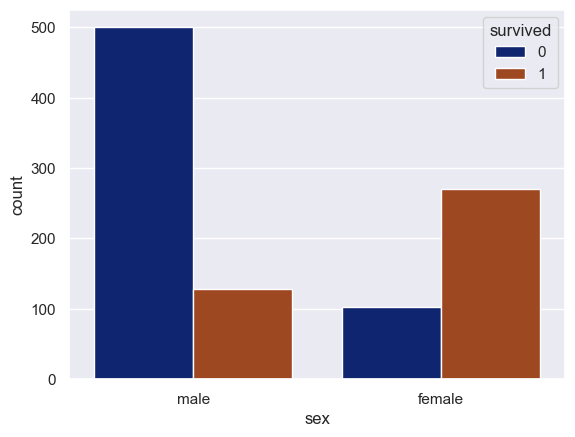

In [610]:
sns.countplot(x='sex', hue='survived', data=data)

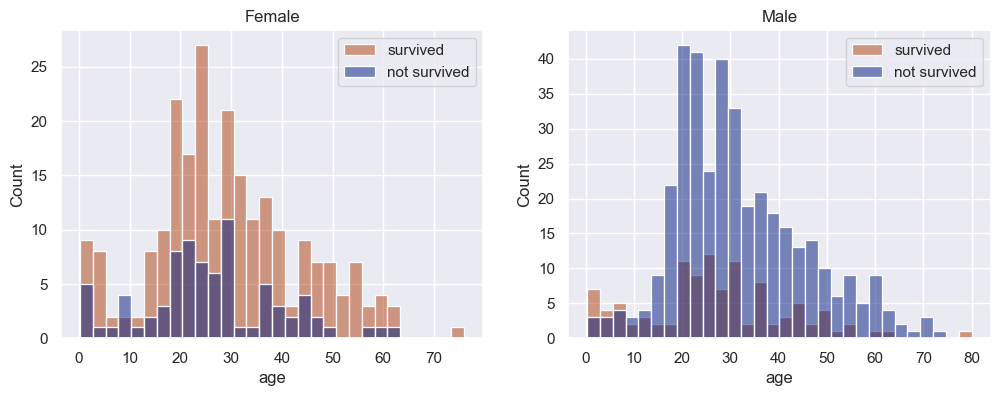

In [611]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
female = data[data['sex']=='female']
male = data[data['sex']=='male']
female['age'].dropna()
male['age'].dropna()

ax = sns.histplot(data=female, x='age', bins=30, ax = axes[0], hue='survived')
ax.legend(['survived', 'not survived'])
ax.set_title('Female')

ax = sns.histplot(data=male, x='age', bins=30, ax = axes[1], hue='survived')
ax.legend(['survived', 'not survived'])
_ = ax.set_title('Male')

Je vidět, že muži mají vysokou pravděpodobnost přežití ve věku 0 až 10 let. U žen je šance na přežití vyšší mezi 20 a 30 lety.
U mužů je pravděpodobnost přežití velmi nízká mezi 20. a 33. rokem života. Ženy mají nejnižší pravděpodobnost ještě mezi 20 a 30 lety.

Také bych měl poznamenat, že kojenci a děti mají o něco vyšší pravděpodobnost přežití. Asi bude rozumne seradit veky podle kategorii.
Z grafu vidime, ze nemame chyby ve veku: nejvyssi je 80, a je to asi jedinecny pripad.

<AxesSubplot:ylabel='age'>

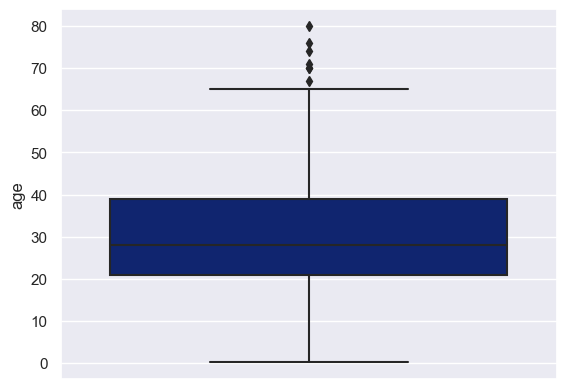

In [612]:
sns.boxplot(y='age',data=data)

Obecné předpoklady jsou pravdivé: většina mužů zemřela při evakuaci žen a dětí.

## Pclass, Embarked a Survived

<AxesSubplot:xlabel='pclass', ylabel='count'>

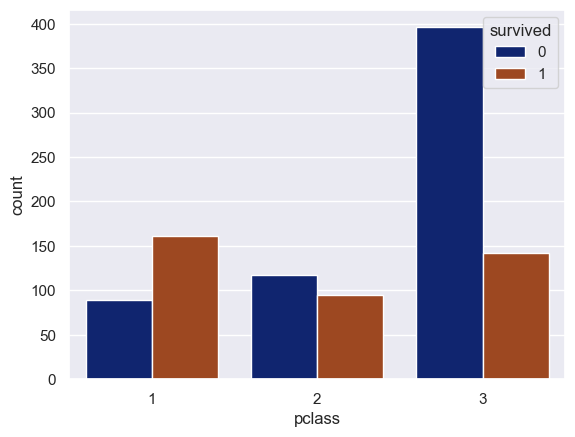

In [613]:
sns.countplot(data=data, x='pclass',hue='survived')

<AxesSubplot:xlabel='embarked', ylabel='count'>

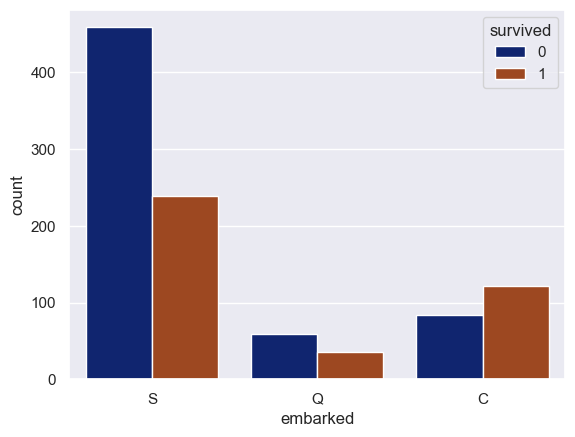

In [614]:
sns.countplot(data=data, x='embarked',hue='survived')

pclass (předvídatelně) koreluje s přežitím: čím vyšší je třída, v čím vyšší palubě cestující žil, tím větší je pravděpodobnost, že přežije.
take vidime, ze cestujici ve 3 tride maji vetsi sanci nepreziti.

embarked má také určitou souvislost: lidé, kteří se nalodili v Southamptonu, mají nižší šanci na přežití než ti, kteří se nalodili v Cherbourgu.

Podívejme se na vztah mezi Sex, Pclass a Survived:

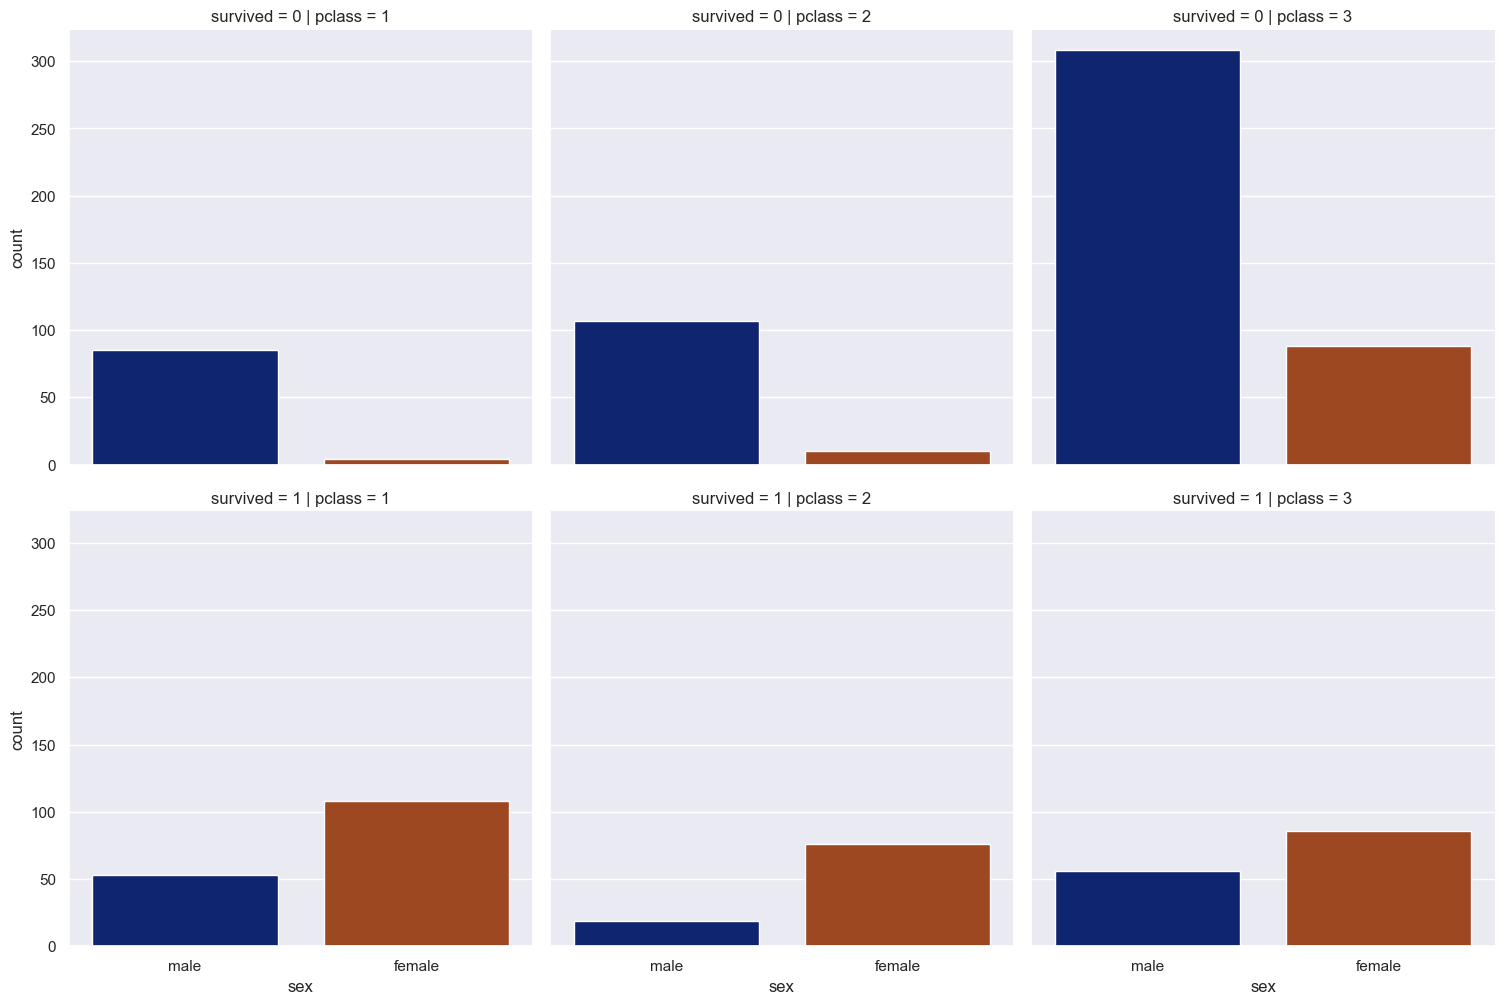

In [615]:
sns.catplot(x='sex', col='pclass', row='survived', data=data, kind='count')

Vidíme, že přežil téměř stejný počet žen bez ohledu na třídu. U mužů je tomu naopak: počet obětí je úměrný třídě.

## Parch, SibSp a Survived

tyto dvě kategorie lze zkombinovat a uvést tak celkový počet příbuzných na lodi:

<AxesSubplot:xlabel='relatives', ylabel='survived'>

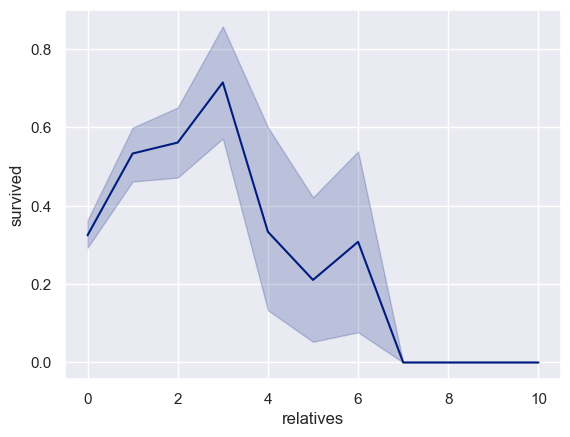

In [616]:
data['relatives'] = data['sibsp'] + data['parch']

sns.lineplot(x='relatives',y='survived',data=data)

Zde vidíme, že jste měli vysokou pravděpodobnost přežití s 1 až 3 příbuznými, ale nižší, pokud jste měli méně než 1 nebo více než 3 příbuzné.

# Priprava dat

## Name a prefix

Pokusime dostat prefixy ze jmen a klasifikovat je:

In [617]:
# Get prefixes from names, group them by rareness
# Source: https://typewind.github.io/2017/07/25/titanic/
# the prefixes can be separated into 4 groups:

# For man: Mr
# For woman: Miss, Mrs, Ms, Mme, Mlle
# Child: Master
# Rare: everyone else

import re

names=data["name"]
prefix=[]

# Using regex mask search for first word after come, which is a prefix
for name in names:
    prefix.append(re.search(',(.*?)\.',name).group(1)) 

data["prefix"]=pd.Series(prefix,index=data.index)
display(data["prefix"].value_counts())

#Get unique prefixes
prefix = data['prefix'].value_counts().reset_index()['index']
# Get all rare prefixes
prefix = prefix[~prefix.isin([" Miss"," Mrs"," Ms"," Mme"," Mlle", " Mr", " Master"])]

data["prefix"] = data["prefix"].replace(" Mr", "Man")
data["prefix"] = data["prefix"].replace([" Miss"," Mrs"," Ms"," Mme"," Mlle"],"Woman")
data["prefix"] = data["prefix"].replace(" Master","Child")

for pr in prefix:
    data['prefix'].replace(pr,"Rare",inplace=True)
display(data["prefix"].value_counts(dropna=False))

 Mr              566
 Miss            210
 Mrs             155
 Master           45
 Dr                7
 Rev               4
 Col               4
 Mlle              2
 Sir               1
 Capt              1
 Dona              1
 Ms                1
 the Countess      1
 Mme               1
 Major             1
Name: prefix, dtype: int64

Man      566
Woman    369
Child     45
Rare      20
Name: prefix, dtype: int64

Jmeno ted muzeme odstranit:

In [618]:
data.drop(['name'],inplace=True,axis='columns')

## Cabin a Deck

Podívejme se, jaké hodnoty má priznak 'cabin':

In [619]:
data['cabin'].value_counts(dropna=False)

NaN                767
B57 B59 B63 B66      5
C23 C25 C27          5
C78                  4
C22 C26              4
                  ... 
D37                  1
C126                 1
A19                  1
E63                  1
D7                   1
Name: cabin, Length: 158, dtype: int64

Zajímavý detail: číslo kabiny se skládá z čísla paluby a samotného čísla kabiny!
Umístění cestujícího na lodi může mít velký vliv na to, zda přežije, nebo ne.
Vyzdvihněme novy priznak: Deck 

In [620]:
def get_decks(value):
     if (pd.isnull(value) or value == "" or value.isnumeric()):
         return np.nan
     return value[:1]


In [621]:
decks = data['cabin'].apply(get_decks)
data['deck'] = pd.Series(decks,index=data.index)
display(data['deck'].value_counts(dropna=False))

NaN    767
C       76
B       55
D       35
E       29
F       17
A       17
G        3
T        1
Name: deck, dtype: int64

Cabin ted muzeme odstranit:

In [622]:
data.drop(['cabin'],inplace=True,axis='columns')

## Rozdělení + míchání dat

K tomu použijeme funkci train_test_split() s náhodným semínkem


In [623]:
# Split ratio: 60% train, 20% validation, 20% test

Xtrain, Xrest, ytrain, yrest = train_test_split( 
      data.drop(columns=['survived']), 
      data['survived'], 
      test_size=0.4, 
      random_state=random_seed
)

Xval, Xtest, yval, ytest = train_test_split( 
      Xrest, 
      yrest, 
      test_size=0.5, 
      random_state=random_seed
)

## Age

Převeďme věk na kategoriální atribut: rozdělme cestující podle jejich věku do několika kategorií:

In [624]:
# Fill NaN age with corresponding median age (for children and adults)
child_age_mean = round(Xtrain['age'][Xtrain['prefix'] == "Child"].mean())
age_mean = round(Xtrain['age'][Xtrain['prefix'] != "Child"].mean())
print("Child median age: ",child_age_mean,"\nAdult median age:",age_mean)

child = Xtrain['age'][Xtrain['prefix'] == "Child"]
child = child.fillna(child_age_mean)
adult = Xtrain['age'][Xtrain['prefix'] != "Child"]
adult = adult.fillna(age_mean)

age = child.combine_first(adult)

Xtrain['age'] = age

child = Xval['age'][Xval['prefix'] == "Child"]
child = child.fillna(child_age_mean)
adult = Xval['age'][Xval['prefix'] != "Child"]
adult = adult.fillna(age_mean)

age = child.combine_first(adult)

Xval['age'] = age

child = Xtest['age'][Xtest['prefix'] == "Child"]
child = child.fillna(child_age_mean)
adult = Xtest['age'][Xtest['prefix'] != "Child"]
adult = adult.fillna(age_mean)

age = child.combine_first(adult)

Xtest['age'] = age

Child median age:  6 
Adult median age: 31


In [625]:
Xtrain['age_category'] = pd.cut(Xtrain['age'], bins=[0, 4, 8, 18, 30, 60, 100],
                              labels=["Infant", "Child", "Teenager", "Young", "Adult", "Senior"])

Xval['age_category'] = pd.cut(Xval['age'], bins=[0, 4, 8, 18, 30, 60, 100],
                              labels=["Infant", "Child", "Teenager", "Young", "Adult", "Senior"])

Xtest['age_category'] = pd.cut(Xtest['age'], bins=[0, 4, 8, 18, 30, 60, 100],
                              labels=["Infant", "Child", "Teenager", "Young", "Adult", "Senior"])

Xtrain.head(10)

,ID,pclass,sex,age,sibsp,parch,ticket,fare,embarked,home.dest,relatives,prefix,deck,age_category
820,820,3,male,31.0,0,0,A/5 1478,8.0500,S,"Bridgwater, Somerset, England",0,Man,NaN,Adult
69,69,3,female,28.0,0,0,349245,7.8958,S,NaN,0,Woman,NaN,Young
564,564,2,male,23.0,0,0,244278,10.5000,S,"Hamilton, ON",0,Rare,NaN,Young
818,818,2,female,50.0,0,1,230433,26.0000,S,"Woodford County, KY",1,Woman,NaN,Adult
393,393,1,female,31.0,1,0,35273,113.2750,C,"Lexington, MA",1,Woman,D,Adult
26,26,3,female,31.0,0,0,A. 2. 39186,8.0500,S,NaN,0,Woman,NaN,Adult
441,441,3,male,31.0,0,0,349220,7.8958,S,NaN,0,Man,NaN,Adult
968,968,1,male,31.0,0,0,F.C. 12998,25.7417,C,"Paris, France",0,Man,NaN,Adult
255,255,3,male,10.0,3,2,347088,27.9000,S,NaN,5,Child,NaN,Teenager
727,727,1,male,46.0,0,0,13050,75.2417,C,"Vancouver, BC",0,Man,C,Adult


Age ted muzeme odstranit:

In [626]:
Xtrain.drop(['age'],inplace=True,axis='columns')
Xval.drop(['age'],inplace=True,axis='columns')
Xtest.drop(['age'],inplace=True,axis='columns')

## Fare, Embarked

Zaplnime stredni hodnotou:

In [627]:
# Fill NaN's in fare
Xtrain['fare'].fillna(Xtrain['fare'].mean(),inplace=True)
Xval['fare'].fillna(Xtrain['fare'].mean(),inplace=True)
Xtest['fare'].fillna(Xtrain['fare'].mean(),inplace=True)

In [628]:
Xtrain['embarked'].describe()

Xtrain['embarked'].fillna("S",inplace=True)
Xval['embarked'].fillna("S",inplace=True)
Xtest['embarked'].fillna("S",inplace=True)

Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 820 to 138
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ID            600 non-null    int64   
 1   pclass        600 non-null    int64   
 2   sex           600 non-null    object  
 3   sibsp         600 non-null    int64   
 4   parch         600 non-null    int64   
 5   ticket        600 non-null    object  
 6   fare          600 non-null    float64 
 7   embarked      600 non-null    object  
 8   home.dest     325 non-null    object  
 9   relatives     600 non-null    int64   
 10  prefix        600 non-null    object  
 11  deck          138 non-null    object  
 12  age_category  600 non-null    category
dtypes: category(1), float64(1), int64(5), object(6)
memory usage: 61.7+ KB


## Zbytečné priznaky

Odstranime priznaky home.dest, id a ticket

In [629]:
Xtrain.drop(columns=["home.dest", "ID", "ticket"],inplace=True,errors="ignore")
Xval.drop(columns=["home.dest", "ID", "ticket"],inplace=True,errors="ignore")
Xtest.drop(columns=["home.dest", "ID", "ticket"],inplace=True,errors="ignore")

Xtrain.info()
Xtrain.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 820 to 138
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   pclass        600 non-null    int64   
 1   sex           600 non-null    object  
 2   sibsp         600 non-null    int64   
 3   parch         600 non-null    int64   
 4   fare          600 non-null    float64 
 5   embarked      600 non-null    object  
 6   relatives     600 non-null    int64   
 7   prefix        600 non-null    object  
 8   deck          138 non-null    object  
 9   age_category  600 non-null    category
dtypes: category(1), float64(1), int64(4), object(4)
memory usage: 47.7+ KB


,pclass,sex,sibsp,parch,fare,embarked,relatives,prefix,deck,age_category
820,3,male,0,0,8.0500,S,0,Man,NaN,Adult
69,3,female,0,0,7.8958,S,0,Woman,NaN,Young
564,2,male,0,0,10.5000,S,0,Rare,NaN,Young
818,2,female,0,1,26.0000,S,1,Woman,NaN,Adult
393,1,female,1,0,113.2750,C,1,Woman,D,Adult
26,3,female,0,0,8.0500,S,0,Woman,NaN,Adult
441,3,male,0,0,7.8958,S,0,Man,NaN,Adult
968,1,male,0,0,25.7417,C,0,Man,NaN,Adult
255,3,male,3,2,27.9000,S,5,Child,NaN,Teenager
727,1,male,0,0,75.2417,C,0,Man,C,Adult


# Kodovani dat

Pro kodovani dat pouzijeme pd.get_dummies a LabelEncoder.

In [630]:
Xtrain = pd.get_dummies(Xtrain,columns=['pclass','embarked'])
Xval = pd.get_dummies(Xval,columns=['pclass','embarked'])
Xtest = pd.get_dummies(Xtest,columns=['pclass','embarked'])

In [631]:
encoders = {}
cat_cols = {'sex','age_category','deck','prefix'}

for col in Xtrain.select_dtypes('object').columns:
    Xtrain[col] = Xtrain[col].fillna('NaN')
    Xtrain[col] = Xtrain[col].astype('category')
    
    Xval[col] = Xval[col].fillna('NaN')
    Xval[col] = Xval[col].astype('category')
    
    Xtest[col] = Xtest[col].fillna('NaN')
    Xtest[col] = Xtest[col].astype('category')

for col in cat_cols:
    categories = Xtrain[col].unique()
    encoders[col] = LabelEncoder()
    encoders[col].fit(Xtrain[col])
    Xtrain[col] = encoders[col].transform(Xtrain[col])

    for idx, val in Xval[col].items():
        if val not in categories:
            Xval.at[idx, col] = 'NaN'
    Xval[col] = encoders[col].transform(Xval[col])

    for idx, val in Xtest[col].items():
        if val not in categories:
            Xtest.at[idx, col] = 'NaN'
    Xtest[col] = encoders[col].transform(Xtest[col])

In [632]:
Xtrain.head(10)

,sex,sibsp,parch,fare,relatives,prefix,deck,age_category,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
820,1,0,0,8.0500,0,1,7,0,0,0,1,0,0,1
69,0,0,0,7.8958,0,3,7,5,0,0,1,0,0,1
564,1,0,0,10.5000,0,2,7,5,0,1,0,0,0,1
818,0,0,1,26.0000,1,3,7,0,0,1,0,0,0,1
393,0,1,0,113.2750,1,3,3,0,1,0,0,1,0,0
26,0,0,0,8.0500,0,3,7,0,0,0,1,0,0,1
441,1,0,0,7.8958,0,1,7,0,0,0,1,0,0,1
968,1,0,0,25.7417,0,1,7,0,1,0,0,1,0,0
255,1,3,2,27.9000,5,0,7,4,0,0,1,0,0,1
727,1,0,0,75.2417,0,1,2,0,1,0,0,1,0,0


In [633]:
Xval.head(10)

,sex,sibsp,parch,fare,relatives,prefix,deck,age_category,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
807,1,1,2,41.5792,3,1,7,5,0,1,0,1,0,0
610,1,0,0,7.2500,0,1,7,5,0,0,1,0,1,0
754,1,0,0,7.8958,0,1,7,5,0,0,1,0,0,1
514,1,1,1,164.8667,2,1,7,0,1,0,0,0,0,1
436,0,4,2,31.2750,6,3,7,1,0,0,1,0,0,1
920,1,0,1,29.7000,1,1,2,0,1,0,0,1,0,0
851,0,0,0,14.5000,0,3,7,0,0,0,1,0,0,1
529,1,0,0,8.0500,0,1,7,0,0,0,1,0,0,1
949,1,0,0,26.0000,0,1,7,5,0,1,0,0,0,1
115,1,0,0,10.5000,0,1,7,5,0,1,0,0,0,1


In [634]:
Xtest.head(10)

,sex,sibsp,parch,fare,relatives,prefix,deck,age_category,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
965,0,0,0,262.3750,0,3,1,0,1,0,0,1,0,0
768,1,0,0,26.2875,0,1,4,0,1,0,0,0,0,1
389,1,0,0,7.2250,0,1,7,0,0,0,1,1,0,0
522,1,0,0,16.1000,0,1,7,5,0,0,1,0,0,1
279,1,0,0,73.5000,0,1,7,4,0,1,0,0,0,1
608,1,0,0,9.0000,0,1,7,5,0,0,1,0,0,1
284,0,0,0,15.7500,0,3,7,4,0,1,0,0,0,1
777,0,0,1,26.0000,1,3,7,5,0,1,0,0,0,1
605,0,1,2,27.7500,3,3,7,1,0,1,0,0,0,1
116,0,1,1,32.5000,2,3,7,0,0,1,0,0,0,1


# Trenovani modelu: vyber nejlepsich hyperparametru

## Tree

Rozhodovací strom je velmi vhodny algoritm pro předpovídání přežití pasažérů na Titaniku:

1. Je snadno srozumitelny a interpretovatelny, muzeme ho vizualizovat a porozumět pravidlům, která se naučil.

2. Rozhodovací strom muze zachytit nelineární vztahy mezi vstupními priznaky a cílovou proměnnou. V nasem datasetu existuji složité vztahy mezi faktory jako věk a pohlaví, trida a misto nalodeni, které ovlivňují přežití.

3. Rozhodovací strom poskytuje informace o důležitosti různých příznaků při rozhodování. To může být užitečné k pochopení, které faktory sehrály klíčovou roli při určování přežití na Titaniku. Na základě těchto údajů je možné data ještě lépe zpracovat, což povede k lepším výsledkům predikce.

Je však důležité si uvědomit, že tento algoritm ma také některá omezení:

1. Rozhodovaci strom muze byt náchylny k přeučení a zachytávat šum ve trénovacích datech.

2. Malé změny v datech mohou vést k různým strukturám stromu, což může být nevýhodou.

In [635]:
param_grid = {
    'max_depth': range(1,30), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []
for params in param_comb:
    clf = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    clf.fit(Xtrain.copy(), ytrain.copy())
    train_acc.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, clf.predict(Xval)))

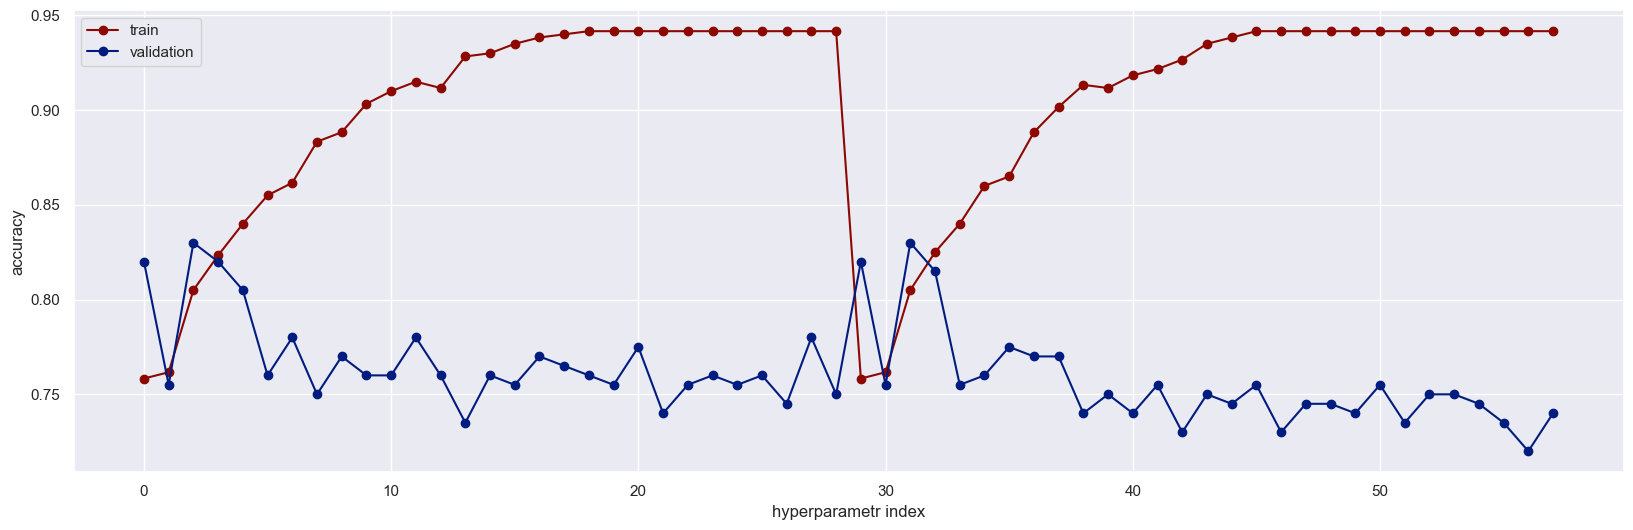

In [636]:

plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [637]:
best_params_val = param_comb[np.argmax(val_acc)]
best_metric_val = max(val_acc)
print(f"Našli jsme nejlepší hyperparametry {best_params_val} s validační přesností {best_metric_val:.4f}.")

Našli jsme nejlepší hyperparametry {'max_depth': 3, 'criterion': 'entropy'} s validační přesností 0.8300.


## KNN

Je mozne použit k-Nearest Neighbors (KNN) pro Titanic dataset. Některé důvody, proč by to mohlo být vhodne:

1. KNN je jednoduchý a intuitivní algoritmus. Nedělá silné předpoklady o distribuci dat, je vhodný pro různé problémy.

2. Predikce vytvořené KNN jsou snadno interpretovatelné. Jelikož závisí na blízkosti datových bodů, je snadné pochopit, jak byla konkrétní predikce vytvořena na základě nejbližších sousedů.

3. KNN, jak i Decision Tree, dokáže zachytit složité vztahy v datech, včetně nelineárních vzorů.

4. KNN dobře funguje na malých až střednich datasets, coz je bas pripad.

5. Algortimus implicitně zohledňuje všechny příznaky v datasetu při tvorbě predikcí.

Nicméně existují také některá nevyhody:

1. S rostoucí velikostí datasetu rostou výpočetní náklady KNN, protože vyžaduje výpočet vzdáleností mezi datovými body. U nas to neni problem, mame jen 1000 zaznamu

2. KNN může být citlivý na šum v datech a irelevantní příznaky. Proto asi je potreba odfiltrovat priznak Fare

3. Algoritmus se nemusí dobře chovat na nerovnovážených datasetech, kde jedna třída výrazně převažuje nad druhou. Tady bohuzel mame takovy pripad (zemřelo mnoho mužů).

Neiprve zkusime najit scaler, ktery dava nejlepsi presnost. Pouzijeme jenom pro priznak 'fare':

In [638]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain.copy())
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)

clf = KNeighborsClassifier()
clf.fit(Xtrain_scaled.copy(), ytrain.copy())

print(f"\nValidation accuracy of standart normalized model: {clf.score(Xval_scaled, yval):0.4f}")

scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain.copy())
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)

clf = KNeighborsClassifier()
clf.fit(Xtrain_scaled.copy(), ytrain.copy())

print(f"Validation accuracy of min-max normalized model: {clf.score(Xval_scaled, yval):0.4f}")


Validation accuracy of standart normalized model: 0.7950
Validation accuracy of min-max normalized model: 0.8100


Vidime, ze je chodne pouzit MinMaxScaler pro nejlepsi predikci:

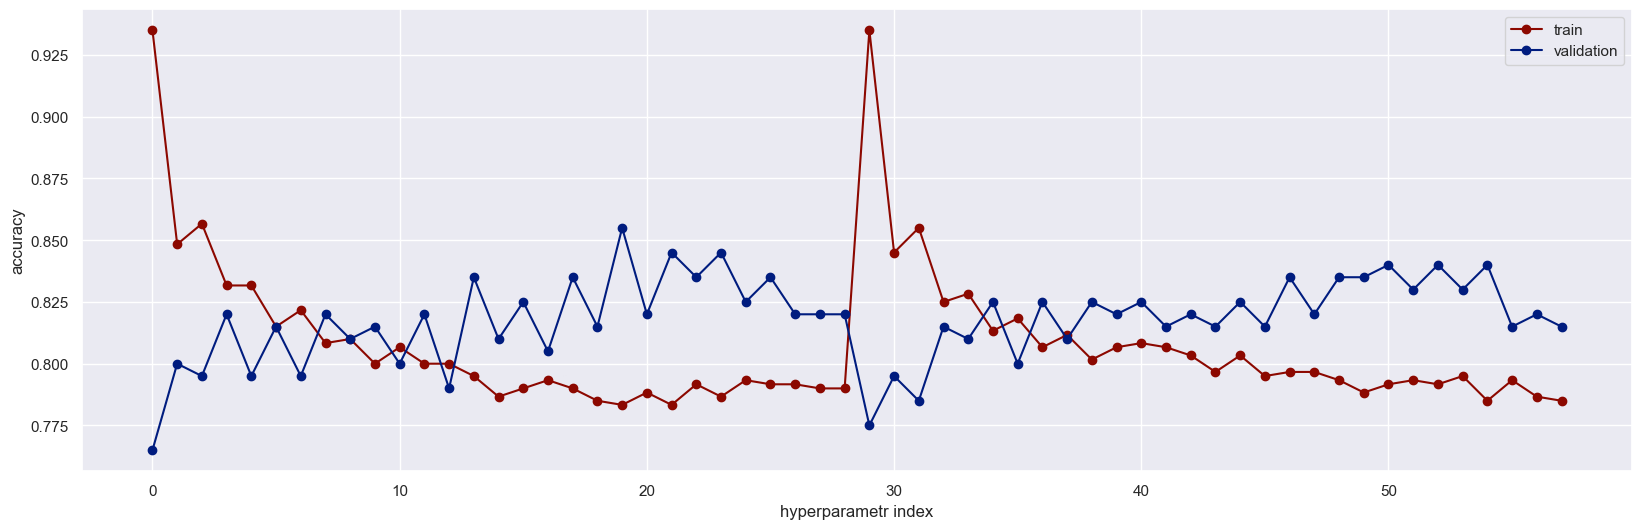

In [639]:
param_grid = {
    'n_neighbors': range(1, 30),
    'metric' : ['manhattan','minkowski']
}   

param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []
for params in param_comb:
    clf = KNeighborsClassifier(n_neighbors = params['n_neighbors'], metric=params['metric'])
    clf.fit(Xtrain_scaled.copy(), ytrain.copy())
    train_acc.append(clf.score(Xtrain_scaled, ytrain))
    val_acc.append(clf.score(Xval_scaled, yval))

plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [640]:
best_params_val_knn = param_comb[np.argmax(val_acc)]
best_metric_val_knn = max(val_acc)
print(f"Našli jsme nejlepší hyperparametry {best_params_val_knn} s validační přesností {best_metric_val_knn:.4f}.")

Našli jsme nejlepší hyperparametry {'n_neighbors': 20, 'metric': 'manhattan'} s validační přesností 0.8550.


Ted' zkusime cross validace:

# Trenovani modelu: metriky

## Tree

Natrenerujeme modely z nejlepsimi parametry a vyvedeme metriky:

Tree
Accuracy score (train): 0.805000
Accuracy score (val): 0.830000

Recall score (val): 0.690141

[[117  12]
 [ 22  49]]

F1 score (val): 0.742424


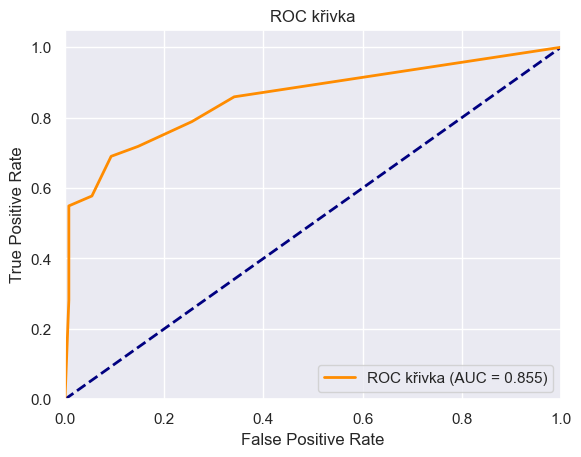

In [641]:
clfDT = DecisionTreeClassifier(**best_params_val)
clfDT.fit(Xtrain_scaled.copy(), ytrain.copy())

print("Tree")
print('Accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, clfDT.predict(Xtrain_scaled))))
print('Accuracy score (val): {0:.6f}\n'.format(metrics.accuracy_score(yval, clfDT.predict(Xval_scaled))))
print('Recall score (val): {0:.6f}\n'.format(metrics.recall_score(yval, clfDT.predict(Xval_scaled))))

cfDT = metrics.confusion_matrix(yval, clfDT.predict(Xval_scaled))
print(cfDT)
print(f'\nF1 score (val): {metrics.f1_score(yval, clfDT.predict(Xval_scaled)):.6f}')

y_pred_proba = clfDT.predict_proba(Xval_scaled)
p1_hat = y_pred_proba[:,1]

fpr, tpr, thresholds = metrics.roc_curve(yval, p1_hat)

AUC = metrics.roc_auc_score(yval, p1_hat)

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right")
plt.show()

Z matice vyplývá, že počet cestujících, kteří přežili a byli klasifikováni jako přeživší (True Positive), je 113.

Počet cestujících, kteří nepřežili a byli klasifikováni jako mrtví (True Negative), je 51. 

Náš dataset dat je mírně nevyvážený, protože katastrofu přežilo mnoho lidí (694 z 1000).

* Přímka ROC (a plocha pod ní AUC) udává poměr mezi TP a FP pro každou prahovou hodnotu. Tato metrika ukazuje, jak dobře náš model klasifikuje předpovědi. Ukazuje, s jakou pravděpodobností bude náhodně vybraný pozitivní příklad zařazen výše než náhodně vybraný negativní příklad.

## KNN

KNN
Accuracy score (train): 0.783333
Accuracy score (val): 0.855000

Recall score (val): 0.718310

[[120   9]
 [ 20  51]]

F1 score (val): 0.778626


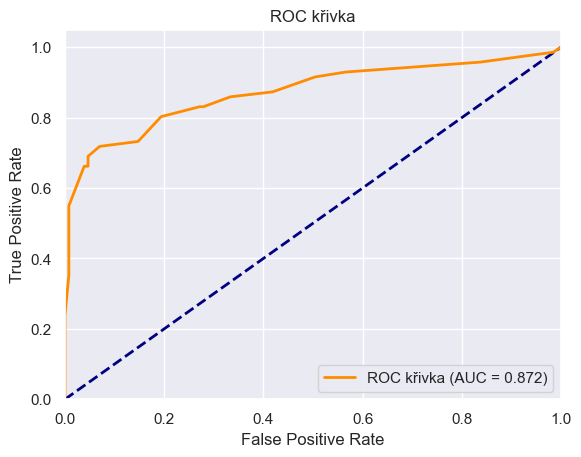

In [642]:
clfKNN = KNeighborsClassifier(**best_params_val_knn)
clfKNN.fit(Xtrain_scaled.copy(), ytrain.copy())

print("KNN")
print('Accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, clfKNN.predict(Xtrain_scaled))))
print('Accuracy score (val): {0:.6f}\n'.format(metrics.accuracy_score(yval, clfKNN.predict(Xval_scaled))))
print('Recall score (val): {0:.6f}\n'.format(metrics.recall_score(yval, clfKNN.predict(Xval_scaled))))

cfKNN = metrics.confusion_matrix(yval, clfKNN.predict(Xval_scaled))
print(cfKNN)
print(f'\nF1 score (val): {metrics.f1_score(yval, clfKNN.predict(Xval_scaled)):.6f}')

y_pred_proba = clfKNN.predict_proba(Xval_scaled)
fpr, tpr, thresholds = metrics.roc_curve(yval, y_pred_proba[:,1])

AUC = metrics.auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right")
plt.show()

Z dokumentace scikit:
* Precision je intuitivně schopnost klasifikátoru neoznačit negativní vzorek jako pozitivní.
* Recall je intuitivně schopnost klasifikátoru najít všechny pozitivní vzorky.

F1 score je harmonický průměr precision a recall a je užitečný především pro datasety, kde P(Y = 1) je
velmi malá - takže tady F1 by neměl být hlavním ukazatelem, podle kterého vybíráme model (přesto bychom ho měli brát v úvahu).


(https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

# Vyber nejlepsiho modelu

Podle metric uvedenych vyse nejlepsi model je KNN: ma vetsi Accuracy, F1 Score a AUC.

Ted natrenujeme model na vshech datech, co mame k dispozici, pred vyhodnocovanim:

In [643]:
best_model = KNeighborsClassifier(**best_params_val_knn)
Xtrain_scaled = np.concatenate((Xtrain_scaled,Xval_scaled),axis=0)
ytrain = pd.concat([ytrain,yval],axis=0)

best_model.fit(Xtrain_scaled,ytrain)
acc = metrics.accuracy_score(ytest, best_model.predict(Xtest_scaled))
print(f"Přesnost, kterou můžeme očekávat na nových datech, je {acc}")

Přesnost, kterou můžeme očekávat na nových datech, je 0.755
